In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append(os.path.abspath(os.pardir))

In [10]:
# %reset
from sympy import symbols, init_printing, simplify, solve, srepr, Add, Symbol, Integer, Float, pi, cos, sin, Rational
from sympy import IndexedBase, Eq, simplify, sqrt, latex
from mako.template import Template
from mako.lookup import TemplateLookup
from mako.runtime import Context
from StringIO import StringIO
from opesci import *
init_printing()

In [28]:
U = IndexedBase('U')
delta = Symbol('Delta')
t, x,y,z = symbols('t x y z')

In [34]:
from opesci.util import Taylor_generic, Deriv_generic

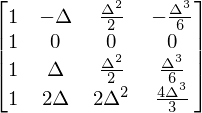

In [22]:
M = Taylor_generic(delta,1,2); M

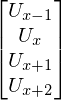

In [24]:
R = Matrix([U[x-1],U[x],U[x+1],U[x+2]]); R

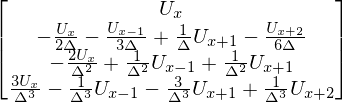

In [25]:
M.inv()*R

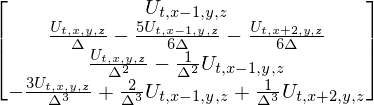

In [43]:
Deriv_generic(U,[t,x,y,z],1,delta,1,2)

In [3]:
Txx = SField('Txx', dimension=3, direction=(1, 1))
Tyy = SField('Tyy', dimension=3, direction=(2, 2))
Tzz = SField('Tzz', dimension=3, direction=(3, 3))
Txy = SField('Txy', dimension=3, direction=(1, 2))
Tyz = SField('Tyz', dimension=3, direction=(2, 3))
Txz = SField('Txz', dimension=3, direction=(1, 3))
U = VField('U', dimension=3, direction=1)
V = VField('V', dimension=3, direction=2)
W = VField('W', dimension=3, direction=3)

In [4]:
grid = StaggeredGrid(dimension=3, domain_size=(1.0, 1.0, 1.0), grid_size=(100, 100, 100), 
                     stress_fields=[Txx, Tyy, Tzz, Txy, Tyz, Txz], velocity_fields=[U, V, W])
grid.set_time_step(0.002, 1.0)
grid.set_switches(omp=True, simd=False, ivdep=True,
                  double=False, expand=True, eval_const=True, converge=True)

In [5]:
t, x, y, z = symbols('t x y z')
grid.set_index([x, y, z])
grid.set_media_params(read=False, rho=1.0, vp=1.0, vs=0.5,
                      rho_file='RHOhomogx200', vp_file='VPhomogx200', vs_file='VShomogx200')
grid.get_time_step_limit()

####Analytical solutions
$U = cos(\pi x)(sin(\pi y)-sin(\pi z))cos(\Omega t)$<br>
$V = cos(\pi y)(sin(\pi z)-sin(\pi x))cos(\Omega t)$<br>
$W = cos(\pi z)(sin(\pi x)-sin(\pi y))cos(\Omega t)$<br>
$T_{xx} = -Asin(\pi x)(sin(\pi y)-sin(\pi z))sin(\Omega t)$<br>
$T_{yy} = -Asin(\pi y)(sin(\pi z)-sin(\pi x))sin(\Omega t)$<br>
$T_{zz} = -Asin(\pi z)(sin(\pi x)-sin(\pi y))sin(\Omega t)$<br>
$T_{xy} = T_{yz} = T_{xz} = 0$<br>
where $A=\sqrt{2\rho \mu} \space \space \Omega=\pi\sqrt{\frac{2\mu}{\rho}}$

In [6]:
rho, beta, lam, mu = symbols('rho beta lambda mu')

Omega = pi*sqrt(2*mu/rho)
A = sqrt(2*rho*mu)
U_func = cos(pi*x)*(sin(pi*y)-sin(pi*z))*cos(Omega*t)
V_func = cos(pi*y)*(sin(pi*z)-sin(pi*x))*cos(Omega*t)
W_func = cos(pi*z)*(sin(pi*x)-sin(pi*y))*cos(Omega*t)
Txx_func = -A*sin(pi*x)*(sin(pi*y)-sin(pi*z))*sin(Omega*t)
Tyy_func = -A*sin(pi*y)*(sin(pi*z)-sin(pi*x))*sin(Omega*t)
Tzz_func = -A*sin(pi*z)*(sin(pi*x)-sin(pi*y))*sin(Omega*t)
Txy_func = Float(0)
Tyz_func = Float(0)
Txz_func = Float(0)

In [7]:
U.set_analytic_solution(U_func)
V.set_analytic_solution(V_func)
W.set_analytic_solution(W_func)
Txx.set_analytic_solution(Txx_func)
Tyy.set_analytic_solution(Tyy_func)
Tzz.set_analytic_solution(Tzz_func)
Txy.set_analytic_solution(Txy_func)
Tyz.set_analytic_solution(Tyz_func)
Txz.set_analytic_solution(Txz_func)

In [12]:
grid.set_accuracy([1,4,4,4])
grid.calc_derivatives()

In [13]:
grid.margin.value

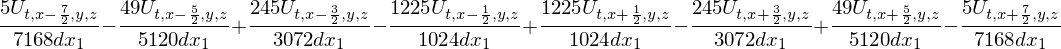

In [14]:
U.d[1][1].fd[4]

###PDEs
#####momentum equations
$\partial_tU = b(\partial_xT_{xx}+\partial_yT_{xy}+\partial_zT_{xz})$<br>
$\partial_tV = b(\partial_xT_{xy}+\partial_yT_{yy}+\partial_zT_{yz})$<br>
$\partial_tW = b(\partial_xT_{xz}+\partial_yT_{yz}+\partial_zT_{zz})$<br>
#####stress-strain equations
$\partial_tT_{xx} = (\lambda+2\mu)\partial_xU + \lambda(\partial_yV+\partial_zW)$<br>
$\partial_tT_{yy} = (\lambda+2\mu)\partial_yV + \lambda(\partial_xU+\partial_zW)$<br>
$\partial_tT_{zz} = (\lambda+2\mu)\partial_zW + \lambda(\partial_xU+\partial_yV)$<br>
$\partial_tT_{xy} = \mu(\partial_yU + \partial_xV)$<br>
$\partial_tT_{xz} = \mu(\partial_zU + \partial_xW)$<br>
$\partial_tT_{yz} = \mu(\partial_zV + \partial_yW)$<br>

In [15]:
# momentum equations
eq1 = Eq(U.d[0][1], beta*(Txx.d[1][1] + Txy.d[2][1] + Txz.d[3][1]))
eq2 = Eq(V.d[0][1], beta*(Txy.d[1][1] + Tyy.d[2][1] + Tyz.d[3][1]))
eq3 = Eq(W.d[0][1], beta*(Txz.d[1][1] + Tyz.d[2][1] + Tzz.d[3][1]))
# stress-strain equations
eq4 = Eq(Txx.d[0][1], (lam + 2*mu)*U.d[1][1] + lam*(V.d[2][1]+W.d[3][1]))
eq5 = Eq(Tyy.d[0][1], (lam + 2*mu)*V.d[2][1] + lam*(U.d[1][1]+W.d[3][1]))
eq6 = Eq(Tzz.d[0][1], (lam + 2*mu)*W.d[3][1] + lam*(U.d[1][1]+V.d[2][1]))
eq7 = Eq(Txy.d[0][1], mu*(U.d[2][1] + V.d[1][1]))
eq8 = Eq(Tyz.d[0][1], mu*(V.d[3][1] + W.d[2][1]))
eq9 = Eq(Txz.d[0][1], mu*(U.d[3][1] + W.d[1][1]))

In [16]:
grid.solve_fd([eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8,eq9])

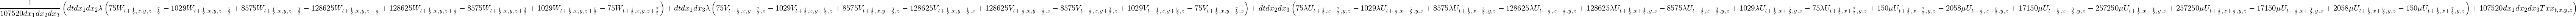

In [17]:
Txx.kernel

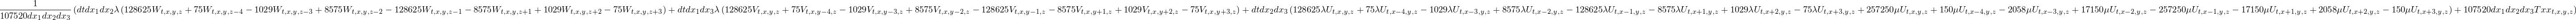

In [18]:
Txx.kernel_aligned

In [31]:
grid.set_free_surface_boundary(dimension=1,side=0)
grid.set_free_surface_boundary(dimension=1,side=1)
grid.set_free_surface_boundary(dimension=2,side=0)
grid.set_free_surface_boundary(dimension=2,side=1)
grid.set_free_surface_boundary(dimension=3,side=0)
grid.set_free_surface_boundary(dimension=3,side=1)

###output using templates

In [36]:
# write to template file
grid.generate('../tmp/test_8order.cpp')

Generated: ../tmp/test_8order.cpp


In [14]:
grid.get_velocity_kernel_ai()

In [15]:
grid.get_stress_kernel_ai()

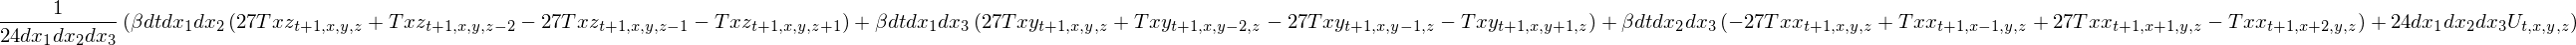

In [17]:
U.kernel_aligned

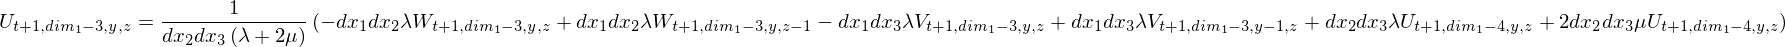

In [24]:
U.bc[1][1][0]

In [19]:
grid.velocity_loop

u'#pragma omp for\nfor(int x=4;x<dim1 - 4;++x){\nfor(int y=4;y<dim2 - 4;++y){\n#pragma GCC ivdep\nfor(int z=4;z<dim3 - 4;++z){\nU[t1][x][y][z]=-2.392578125e-1*Txx[t1][x][y][z] + 1.39508928571429e-4*Txx[t1][x - 3][y][z] - 1.9140625e-3*Txx[t1][x - 2][y][z] + 1.59505208333333e-2*Txx[t1][x - 1][y][z] + 2.392578125e-1*Txx[t1][x + 1][y][z] - 1.59505208333333e-2*Txx[t1][x + 2][y][z] + 1.9140625e-3*Txx[t1][x + 3][y][z] - 1.39508928571429e-4*Txx[t1][x + 4][y][z] + 2.392578125e-1*Txy[t1][x][y][z] + 1.39508928571429e-4*Txy[t1][x][y - 4][z] - 1.9140625e-3*Txy[t1][x][y - 3][z] + 1.59505208333333e-2*Txy[t1][x][y - 2][z] - 2.392578125e-1*Txy[t1][x][y - 1][z] - 1.59505208333333e-2*Txy[t1][x][y + 1][z] + 1.9140625e-3*Txy[t1][x][y + 2][z] - 1.39508928571429e-4*Txy[t1][x][y + 3][z] + 2.392578125e-1*Txz[t1][x][y][z] + 1.39508928571429e-4*Txz[t1][x][y][z - 4] - 1.9140625e-3*Txz[t1][x][y][z - 3] + 1.59505208333333e-2*Txz[t1][x][y][z - 2] - 2.392578125e-1*Txz[t1][x][y][z - 1] - 1.59505208333333e-2*Txz[t1][x]

In [21]:
grid.get_velocity_kernel_ai()

In [22]:
grid.get_stress_kernel_ai()

In [32]:
U.bc

[[None, None],
 [[U[t + 1, 3, y, z] == 0,
   U[t + 1, 2, y, z] == 0,
   U[t + 1, 1, y, z] == 0,
   U[t + 1, 0, y, z] == 0],
  [U[t + 1, dim1 - 5, y, z] == 0,
   U[t + 1, dim1 - 4, y, z] == 0,
   U[t + 1, dim1 - 3, y, z] == 0,
   U[t + 1, dim1 - 2, y, z] == 0]],
 [[U[t + 1, x, 3, z] == 0,
   U[t + 1, x, 2, z] == 0,
   U[t + 1, x, 1, z] == 0,
   U[t + 1, x, 0, z] == 0],
  [U[t + 1, x, dim2 - 4, z] == 0,
   U[t + 1, x, dim2 - 3, z] == 0,
   U[t + 1, x, dim2 - 2, z] == 0,
   U[t + 1, x, dim2 - 1, z] == 0]],
 [[U[t + 1, x, y, 3] == 0,
   U[t + 1, x, y, 2] == 0,
   U[t + 1, x, y, 1] == 0,
   U[t + 1, x, y, 0] == 0],
  [U[t + 1, x, y, dim3 - 4] == 0,
   U[t + 1, x, y, dim3 - 3] == 0,
   U[t + 1, x, y, dim3 - 2] == 0,
   U[t + 1, x, y, dim3 - 1] == 0]]]

In [30]:
Txx.bc

[[None, None],
 [[Txx[t + 1, 4, y, z] == 0,
   Txx[t + 1, 3, y, z] == -Txx[t + 1, 5, y, z],
   Txx[t + 1, 2, y, z] == -Txx[t + 1, 6, y, z],
   Txx[t + 1, 1, y, z] == -Txx[t + 1, 7, y, z]],
  [Txx[t + 1, dim1 - 5, y, z] == 0,
   Txx[t + 1, dim1 - 4, y, z] == -Txx[t + 1, dim1 - 6, y, z],
   Txx[t + 1, dim1 - 3, y, z] == -Txx[t + 1, dim1 - 7, y, z],
   Txx[t + 1, dim1 - 2, y, z] == -Txx[t + 1, dim1 - 8, y, z]]],
 [[], []],
 [[], []]]

In [33]:
grid.velocity_bc

u'#pragma omp for\nfor(int y=1;y<dim2 - 1;++y){\n#pragma GCC ivdep\nfor(int z=1;z<dim3 - 1;++z){\nU[t1][3][y][z] = 0;\nU[t1][2][y][z] = 0;\nU[t1][1][y][z] = 0;\nU[t1][0][y][z] = 0;\n}\n}\n#pragma omp for\nfor(int y=1;y<dim2 - 1;++y){\n#pragma GCC ivdep\nfor(int z=1;z<dim3 - 1;++z){\nU[t1][dim1 - 5][y][z] = 0;\nU[t1][dim1 - 4][y][z] = 0;\nU[t1][dim1 - 3][y][z] = 0;\nU[t1][dim1 - 2][y][z] = 0;\n}\n}\n#pragma omp for\nfor(int y=1;y<dim2 - 1;++y){\n#pragma GCC ivdep\nfor(int z=1;z<dim3 - 1;++z){\nV[t1][3][y][z] = 0;\nV[t1][2][y][z] = 0;\nV[t1][1][y][z] = 0;\nV[t1][0][y][z] = 0;\n}\n}\n#pragma omp for\nfor(int y=1;y<dim2 - 1;++y){\n#pragma GCC ivdep\nfor(int z=1;z<dim3 - 1;++z){\nV[t1][dim1 - 4][y][z] = 0;\nV[t1][dim1 - 3][y][z] = 0;\nV[t1][dim1 - 2][y][z] = 0;\nV[t1][dim1 - 1][y][z] = 0;\n}\n}\n#pragma omp for\nfor(int y=1;y<dim2 - 1;++y){\n#pragma GCC ivdep\nfor(int z=1;z<dim3 - 1;++z){\nW[t1][3][y][z] = 0;\nW[t1][2][y][z] = 0;\nW[t1][1][y][z] = 0;\nW[t1][0][y][z] = 0;\n}\n}\n#pragma omp 

In [35]:
grid.set_switches(omp=True, simd=False, ivdep=True,
                  double=False, expand=True, eval_const=True, converge=True)